# Data analysis Nencki summer school

This Jupyter Notebook contains the data analysis tutorial we did on Friday during the summer school. The analysis is meant to get some of the interesting data out of the coordinates collected from robots. 

In [133]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.spatial import distance

In [134]:
data = np.genfromtxt(os.path.join('C:\\','Users','Dori','Documents','Nencki','data', 'Martyna_Alisea_Vasyl', 'Experiment_track42.csv'), 
                     delimiter=',', skip_header=1)
# data = data[:,1:]

### Plotting the trajectory
To plot the trajectory we need to plot the y (2nd column) against the x (1st column) variables.

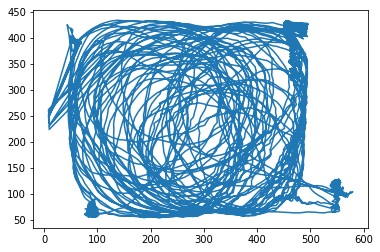

In [135]:
plt.plot(data[:,0], data[:,1])

### Distance and cumulative distance
You can use the coordinates to calculate the distance. The distance between each set of coordinates in the list is distance.euclidean(coor1, coor2). We need to loop through the list and do this for each element. The cumulative distance is the addition of the distance at each point. 

In [136]:
total_dist = [0] # Start with [0] to make it same length as data
cumdist = [0] # Start with [0] to make it same length as data
for i, coor in enumerate(data[:-1]):
    dist = distance.euclidean(coor, data[i+1])
    total_dist.append(dist)
    cumdist.append(cumdist[-1]+dist)

Text(0.5, 0, 'Time (s)')

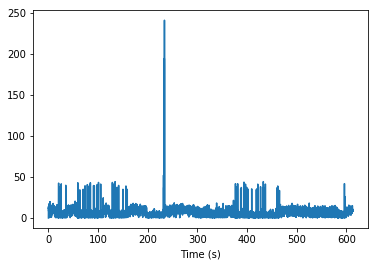

In [137]:
frames = np.arange(len(total_dist))
fps = 25
time = frames/fps
plt.plot(time,total_dist)
plt.xlabel('Time (s)')


93504.31489144886


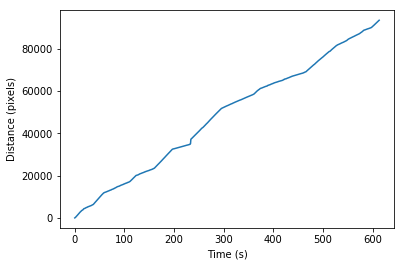

In [139]:
plt.plot(time,cumdist)
plt.xlabel('Time (s)')
plt.ylabel('Distance (pixels)')
tot_dist = cumdist[-1] # Total distance is the last element of this array
print(tot_dist)

### Velocity
We can calculate velocity from distance by taking the differential of the distance (np.diff). Then we can take for example the first 5 seconds of this array and calculate the average velocity over the first 5 seconds (do seconds * fps to get it in frames).

(15326,)
15327


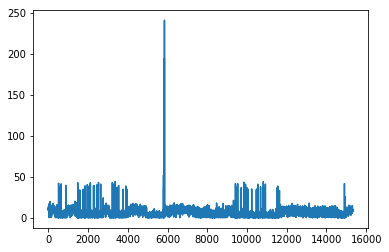

In [141]:
velocity = np.diff(cumdist)
plt.plot(velocity)
print(velocity.shape)
print(len(cumdist))

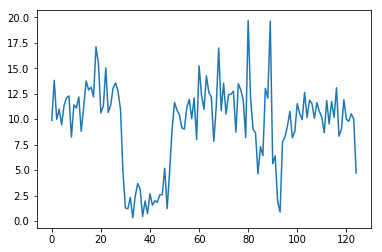

In [142]:
# Speed first 5 seconds
firstfive = velocity[:fps*5]
plt.plot(firstfive)

In [143]:
np.nanmean(firstfive)
np.nanstd(firstfive)

4.118011277510708

### Fixing outliers
Our data has some outliers. We can take them out in two ways, either with a for-loop, or immediately using indexing (better way). We then replace them with np.nan, so we don't misalign our data.

In [144]:
threshold = np.nanmean(velocity) + 3*np.nanstd(velocity)
print(threshold)
for i, el in enumerate(velocity):
    if el > threshold:
        velocity[i] = np.nan 



26.319312673310318


In [145]:
velocity[velocity>threshold] = np.nan ## Better way

C:\Users\Dori\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


In [146]:
np.sum(np.isnan(velocity))

115

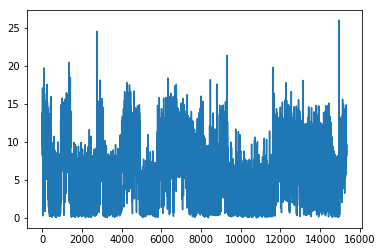

In [147]:
plt.plot(velocity)

### ROI calculations
Sometimes you will have an ROI and you want to compare what happens inside the ROI to what happens outside the ROI. We will first define a ROI (in this case a square), though usually you will have your ROI predefined or you get it from Bonsai. 

We can show the ROI on our plot:

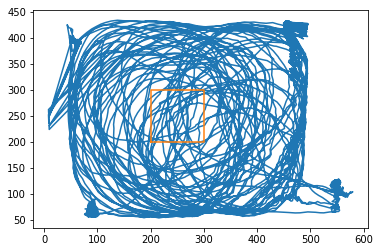

In [148]:
roi = np.array([[200, 200],
                [200, 300],
                [300, 300],
                [300, 200],
                [200, 200]])
plt.plot(data[:,0], data[:,1])
plt.plot(roi[:,0], roi[:,1])

If we want to check whether one coordinate (m) is inside of the roi, we just check if it both above the minimum of the roi, and below the maximum of the roi. The method below will do this automatically for both X and Y, and then we can use np.all to check if it is True for both X and Y

In [61]:
m = [150,250]
lower = m > np.min(roi)
upper = m < np.max(roi)
np.all(lower & upper)
data[1]

array([175.9957 ,  96.49648])

We can now put that into a for-loop and check for each time point if the location is within the array

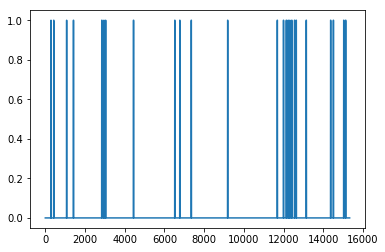

In [149]:
in_roi = []
for coor in data:
    lower = coor > np.min(roi)
    upper = coor < np.max(roi)
    in_roi.append(np.all(lower & upper))
plt.plot(in_roi)

In [151]:
np.sum(in_roi) # Total time spent in ROI
np.nanmean(in_roi) # Percentage of time spent in ROI
np.sum(in_roi)/len(in_roi) # Percentage of time spent in ROI (alternative)

0.015723885952893587

We can also easily check the number of entries into the ROI. We can do this by using the np.diff function again. This function will simply calculate the difference the current and next element in the array (over the entire array). Thus a 1 is an entry, a 0 means it stayed in the same place, and a -1 is an exit

2


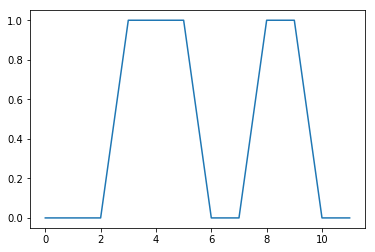

In [152]:
in_roi_test = [0,0,0,1,1,1,0,0,1,1,0,0]
diff_test = np.diff(in_roi_test)
number_entries = np.sum(diff_test==1)
print(number_entries)
plt.plot(in_roi_test)

50
241


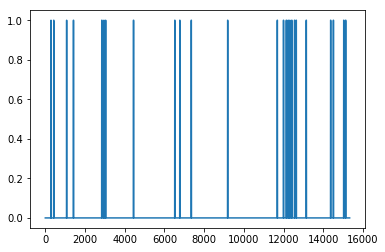

In [153]:
diff_test = np.diff(in_roi)
number_entries = np.sum(diff_test==1)
print(number_entries)
plt.plot(in_roi)
print(sum(in_roi))

We can plot these times of entry onto our original lineplot

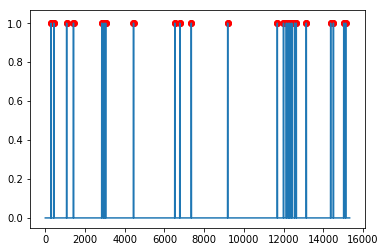

In [154]:
example = np.array([True, False, False, True, False])
time_of_entry = np.where(diff_test==1)[0]
plt.plot(in_roi)
plt.scatter(time_of_entry, np.ones_like(time_of_entry), color='red')

We can lastly calculate the average velocity (or any other thing you are measuring) inside the ROI compared to outside the ROI. We can just use in_roi as an index, and make not_in_roi to select all the time points the animal/robot was not inside the ROI.

In [155]:
not_in_roi = []
for el in in_roi:
    not_in_roi.append(not el)

# List comprehension
[not el for el in in_roi]

vel_in_roi = velocity[in_roi[:-1]]
print('mean: ', np.nanmean(vel_in_roi))
print(np.nanstd(vel_in_roi))
vel_out_roi = velocity[not_in_roi[:-1]]
print('mean: ', np.nanmean(vel_out_roi))
print(np.nanstd(vel_out_roi))


mean:  9.740516690471347
2.6116944204407506
mean:  5.686108921915228
3.816853626801804


We use a barplot to plot this. We want to add error bars and set the correct xticks to make it nice and neat

([<matplotlib.axis.XTick at 0x221e37898d0>,
 <a list of 2 Text xticklabel objects>)

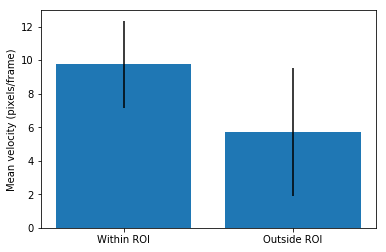

In [129]:
vel_data = [np.nanmean(vel_in_roi), np.nanmean(vel_out_roi)]
vel_std = [np.nanstd(vel_in_roi), np.nanstd(vel_out_roi)]
x = np.arange(len(vel_data))
plt.bar(x , vel_data, yerr=vel_std)
plt.ylabel('Mean velocity (pixels/frame)')
plt.xticks(x, labels = ['Within ROI', 'Outside ROI'])

If you want to go on to do statistics on this, you can use the Scipy stats package (https://docs.scipy.org/doc/scipy/reference/stats.html) This package doesn't like nan values, so you have to delete them first by using np.isnan. 